In [3]:
import duckdb
import polars as pl
from polars import col as c
import polars.selectors as cs
from config import BASE_PARQUET_PATH, DATABASE_URL, HOSPITAL_TABLE_APP
from data_loaders import DataLoaders as dl
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display, HTML

## Hospital Analysis

Using the hospital data stored in the `hospital_directory` table of the duckdb database, perform the following analyses:

1. Determine the total number of hospitals processed `processed`
2. Determine the number of hospitals with files compliant with CMS requirements `compliant`
3. Determine the number of hospitals with drugs listed in the file `has_drugs`
4. Determine the number of hospitals with drugs and corresponding prices `has_prices`

In [4]:
def run_query(query: str) -> pl.LazyFrame:
    with duckdb.connect(DATABASE_URL) as con:
        return pl.DataFrame(con.execute(query=query).fetch_arrow_table()).lazy()

def base_query():
    sql = f"""select * from facility_directory"""
    return run_query(sql)

def render_figure(fig, name):
    # Save a static PNG (will be embedded in the notebook output and therefore visible on GitHub)
    png_path = f"fig/{name}.png"
    html_path = f"fig/{name}.html"

    # write static PNG (requires kaleido)
    fig.write_image(png_path, width=800, height=600, scale=2)

    # write interactive HTML (can be opened in a browser)
    fig.write_html(html_path, include_plotlyjs="cdn", full_html=True)

    # display the PNG inline (this output will be stored in the notebook and rendered by GitHub)
    display(Image(png_path))

    # provide a link to the interactive HTML file in the repo
    display(HTML(f'<a href="{html_path}" target="_blank">Open interactive figure (new tab)</a>'))

In [3]:
(
base_query()
.select(cs.boolean().exclude('converted').sum())
.collect(engine='streaming')
.to_pandas()
)

,downloaded,converted_to_parquet,processed,compliant,has_drugs,has_pricing,error
0,2253,2171,0,2023,1649,1339,67


In [4]:
(
base_query()
.select(cs.boolean().exclude('converted').sum())
.with_columns((pl.all() / c.processed).round(4).name.suffix('_pct'))
.select(cs.matches('.*_pct').exclude('processed_pct'))
.collect(engine='streaming')
.to_pandas()
)

,downloaded_pct,converted_to_parquet_pct,compliant_pct,has_drugs_pct,has_pricing_pct,error_pct
0,inf,inf,inf,inf,inf,inf


### Overall Summary Statistics
- 2,992 files were processed of which 87% were compliant with CMS requirements. 71% of the files had drugs listed and 34% had both drugs and corresponding prices.

## State based Summary Statistics

In [5]:
(
base_query()
.group_by("state")
.agg(cs.boolean().exclude('converted').sum())
.sort("state")
.collect(engine='streaming')
.to_pandas()
)

,state,downloaded,converted_to_parquet,processed,compliant,has_drugs,has_pricing,error
0,AK,26,26,0,22,19,14,2
1,AL,51,48,0,47,33,26,0
2,AR,51,48,0,42,34,30,5
3,AZ,51,51,0,49,25,24,0
4,CA,51,48,0,44,38,25,0
5,CO,51,50,0,46,43,40,1
6,CT,32,30,0,30,19,15,0
7,DE,14,12,0,12,7,5,0
8,FL,51,45,0,43,35,25,0
9,GA,51,47,0,45,39,25,0


In [6]:
(
base_query()
.group_by("state")
.agg(cs.boolean().exclude('converted').sum())
.with_columns((cs.matches('(?i)comp|has') / c.processed).round(4).name.suffix('_pct'))
.select(cs.matches('state|.*_pct').exclude('processed_pct'))
.sort("state")
.collect(engine='streaming')
.to_pandas()
)

,state,compliant_pct,has_drugs_pct,has_pricing_pct
0,AK,inf,inf,inf
1,AL,inf,inf,inf
2,AR,inf,inf,inf
3,AZ,inf,inf,inf
4,CA,inf,inf,inf
5,CO,inf,inf,inf
6,CT,inf,inf,inf
7,DE,inf,inf,inf
8,FL,inf,inf,inf
9,GA,inf,inf,inf


### Hospital Bed Count for Facilities with Pricing Data

In [7]:
(
base_query()
.filter(c.has_pricing)
# remove facilities with 0 beds or null bed counts
.filter(c.beds > 0)
# determine average, min, and max bed counts
.select(
    c.beds.mean().cast(pl.Int16).alias('avg_beds'),
    c.beds.median().cast(pl.Int16).alias('median_beds'),
    c.beds.min().alias('min_beds'),
    c.beds.max().alias('max_beds'),
    c.beds.std().cast(pl.Int16).alias('std_beds'),
    )
.collect(engine='streaming')
.to_pandas()
)

,avg_beds,median_beds,min_beds,max_beds,std_beds
0,130,63,4,956,159


[Text(0.5, 1.0, 'Distribution of Bed Counts for Hospitals with Pricing Data')]

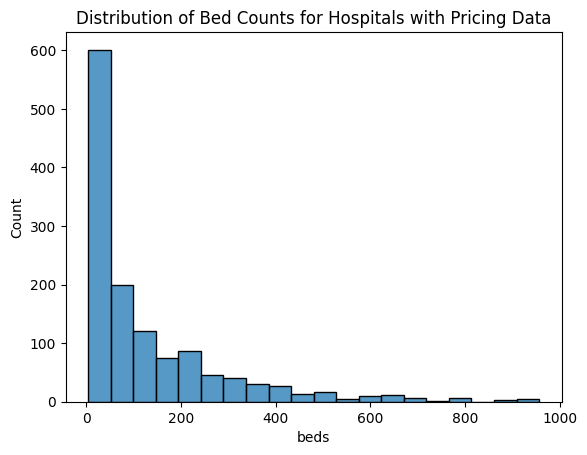

In [10]:
q = (
base_query()
.collect(engine='streaming')
.filter(c.has_pricing)
.filter(c.beds > 0)
)
sns.histplot(q.to_pandas(), x='beds', bins=20).set(title = 'Distribution of Bed Counts for Hospitals with Pricing Data')

### 340B Status for Facilities in Directory with Pricing Data

In [8]:
(
pl.scan_parquet(HOSPITAL_TABLE_APP)
.group_by(c.is_340b)
.agg(pl.len().alias('num_facilities'))
# calc pct of total
.with_columns(
    (c.num_facilities / c.num_facilities.sum()).round(2).alias('pct_facilities')
)
.collect(engine='streaming')
.to_pandas()
)

,is_340b,num_facilities,pct_facilities
0,False,1304,0.97
1,True,40,0.03


### What is the drug converage characteristics of hospitals
- Drugs Unique is GPI-10 unique count

In [11]:
(
dl
.load_hospital_price_table_with_drug_names()
.group_by('hospital_id')
# get unique counts of drug_name, hcpcs, ndc at hospital level
.agg(
    c.drug_name.n_unique().alias('drugs_unique'),
    c.hcpcs.n_unique().alias('hcpcs_unique'),
    c.ndc.n_unique().alias('ndcs_unique')
)
.select(
    # get average, min, max, stddev of unique drug_name, hcpcs, ndc counts across hospitals
    cs.numeric().mean().cast(pl.Int32).name.prefix('avg_'),
    cs.numeric().min().cast(pl.Int32).name.prefix('min_'),
    cs.numeric().max().cast(pl.Int32).name.prefix('max_'),
    cs.numeric().std().cast(pl.Int32).name.prefix('std_'),
)
.collect(engine="streaming")
.transpose(include_header=True)
.to_pandas()
)


,column,column_0
0,avg_drugs_unique,287
1,avg_hcpcs_unique,336
2,avg_ndcs_unique,526
3,min_drugs_unique,1
4,min_hcpcs_unique,1
5,min_ndcs_unique,1
6,max_drugs_unique,1415
7,max_hcpcs_unique,1104
8,max_ndcs_unique,8936
9,std_drugs_unique,224


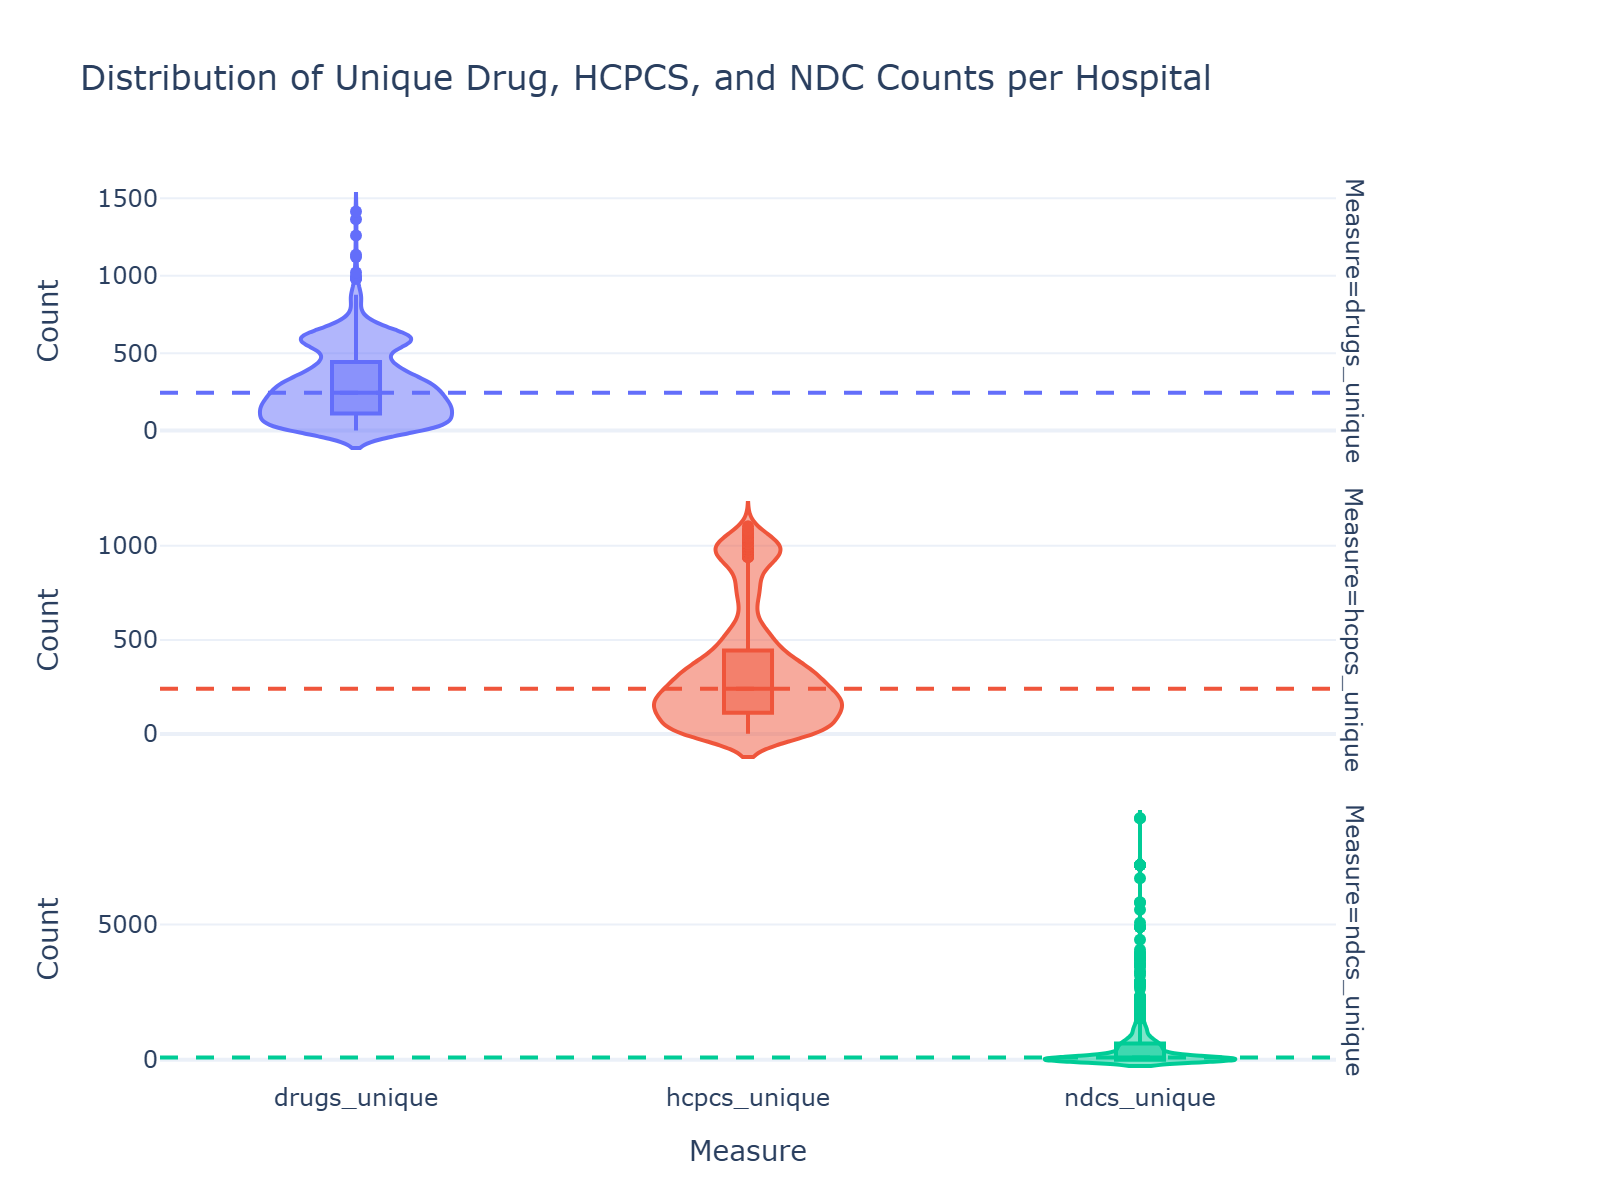

In [10]:
q = (
dl
.load_hospital_price_table_with_drug_names()
.group_by('hospital_id')
# get unique counts of drug_name, hcpcs, ndc at hospital level
.agg(
    c.drug_name.n_unique().alias('drugs_unique'),
    c.hcpcs.n_unique().alias('hcpcs_unique'),
    c.ndc.n_unique().alias('ndcs_unique')
)
.unpivot(index='hospital_id')
)

# Improved plot: violin + box, independent y-scales, median lines and cleaner layout
df = q.collect(engine='streaming').to_pandas()
order = ['drugs_unique', 'hcpcs_unique', 'ndcs_unique']
color_map = {'drugs_unique': '#636efa', 'hcpcs_unique': '#ef553b', 'ndcs_unique': '#00cc96'}

fig = px.violin(
    df,
    x='variable',
    y='value',
    facet_row='variable',
    category_orders={'variable': order},
    color='variable',
    color_discrete_map=color_map,
    box=True,
    points='outliers',
    title='Distribution of Unique Drug, HCPCS, and NDC Counts per Hospital',
    labels={'variable': 'Measure', 'value': 'Count'},
    height=900,
    width=700,
)

# allow each facet to use its own y-scale
fig.update_yaxes(matches=None)
# cleaner appearance
fig.update_layout(
    template='plotly_white',
    showlegend=False,
    violinmode='overlay',
    margin=dict(l=80, r=120, t=90, b=60),
    #facet_row_spacing=0.06
)

# consistent hover and reduced marker size for outliers
fig.update_traces(hovertemplate='Measure=%{x}<br>Count=%{y}<extra></extra>',
                  selector=dict(type='violin'))
fig.update_traces(marker=dict(size=4), selector=dict(mode='markers'))

# add dashed median line for each facet
medians = df.groupby('variable')['value'].median().to_dict()
# facets are ordered from bottom (1) to top (n), so iterate accordingly
for i, var in enumerate(reversed(order), start=1):
    fig.add_hline(y=float(medians[var]), line_dash='dash', line_color=color_map[var], row=i, col=1)

render_figure(fig, name="fig_drug_counts")